In [2]:
import logging
import pathlib
import shutil
import sys
import os
logging.basicConfig()

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tdc import Evaluator
import numpy as np

from rdkit import Chem
from rdkit.Chem import MACCSkeys

sys.path.append('..')
from sbap.sdf import ChemblSdfReader
from sbap.featurizers.prolif_smina import SminaDockingPersistenceHandler, SminaConfig, DockedProlifFingerprintFeaturizer, SminaDockingScoreFeaturizer

In [3]:
sdf_file = pathlib.Path("../molecules/CYP2C8_IC50_CHEMBL_data.sdf")
protein_pdb_file = pathlib.Path("../molecules/2nni_CYP2C8_cleaned.pdb")
docked_ligands_target_directory = pathlib.Path("../molecules/CYP2C8")

fingerprint_featurizer = DockedProlifFingerprintFeaturizer.create(
    logging_level=logging.INFO,
)
docking_score_featurizer = SminaDockingScoreFeaturizer(logging.INFO)

In [4]:
fingerprint_featurizer.fit(protein_pdb_file, docked_ligands_target_directory)

  0%|          | 0/742 [00:00<?, ?it/s]

In [13]:
X, y = fingerprint_featurizer.transform(protein_pdb_file, docked_ligands_target_directory)
X.shape

  0%|          | 0/742 [00:00<?, ?it/s]

INFO:ProlifInteractionFingerprintGenerator:Receptor interactions found: Index(['ILE50.A CustomVdWContact', 'PHE69.A CustomVdWContact',
       'ASN72.A CustomVdWContact', 'ILE74.A CustomVdWContact',
       'ARG97.A CustomVdWContact', 'GLY98.A HBDonor',
       'GLY98.A CustomVdWContact', 'ASN99.A HBDonor',
       'ASN99.A CustomVdWContact', 'SER100.A HBDonor',
       ...
       'LYS383.A CustomVdWContact', 'GLY384.A CustomVdWContact',
       'THR386.A CustomVdWContact', 'MET388.A Hydrophobic',
       'MET388.A CustomVdWContact', 'ILE476.A Hydrophobic',
       'ILE476.A CustomVdWContact', 'VAL477.A CustomVdWContact',
       'HEM500.A Hydrophobic', 'HEM500.A CustomVdWContact'],
      dtype='object', length=104)


(742, 105)

In [14]:
print(X[:10, 0])

[ -9.8 -10.2 -12.1  -9.1  -8.2  -8.9 -10.  -10.2  -9.5 -10.2]


Well, this is definitely not elegant, but... I just want to verify quickly, ok?
Outline:
- read the contents of labels.csv
- calculate each ligand's MACCS
- concat X with this matrix

In [37]:
filename=os.path.join(docked_ligands_target_directory, '79a5c78c-e746-4f12-b7b2-194605833e34.mol')
with open(filename, 'r') as file:
    for line in file:
        print(line)
mol = Chem.MolFromMolFile(filename, removeHs=False, sanitize=False, strictParsing=False)
print(type(mol))
Chem.SanitizeMol(mol)
MACCSkeys.GenMACCSKeys(mol).ToBitString()

*****

     RDKit          3D



 27 30  0  0  0  0  0  0  0  0999 V2000

   46.6844   13.3420  -22.6038 C   0  0  0  0  0  1  0  0  0  0  0  0

   46.6990   13.1423  -24.0896 C   0  0  0  0  0  0  0  0  0  0  0  0

   45.9722   12.1015  -24.6555 C   0  0  0  0  0  3  0  0  0  0  0  0

   45.9045   11.8480  -25.9799 N   0  0  0  0  0  0  0  0  0  0  0  0

   46.5829   12.6681  -26.8174 C   0  0  0  0  0  0  0  0  0  0  0  0

   47.3516   13.7239  -26.3308 C   0  0  0  0  0  3  0  0  0  0  0  0

   47.4200   13.9772  -24.9555 C   0  0  0  0  0  0  0  0  0  0  0  0

   46.4666   12.3436  -28.2517 C   0  0  0  0  0  0  0  0  0  0  0  0

   46.8615   11.0780  -28.7318 C   0  0  0  0  0  3  0  0  0  0  0  0

   46.7587   10.7532  -30.0865 C   0  0  0  0  0  0  0  0  0  0  0  0

   47.2590    9.2007  -30.6340 Cl  0  0  0  0  0  0  0  0  0  0  0  0

   46.2560   11.6763  -30.9991 C   0  0  0  0  0  3  0  0  0  0  0  0

   45.8499   12.9299  -30.5492 C   0  0  0  0  0  3  0  0  0  0  0  0

   

[15:44:44] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25


KekulizeException: Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25

In [31]:
X2 = []

with open(os.path.join(docked_ligands_target_directory, 'labels.csv'), 'r') as file:
    for line in file:
        filename = line.split(",")[0] + '.mol'
        filename = os.path.join(docked_ligands_target_directory, filename)
        mol = Chem.MolFromMolFile(filename, removeHs=False, sanitize=False, strictParsing=True)
        print(type(mol))
        X2.append(MACCSkeys.GenMACCSKeys(mol).ToBitString())
X2 = np.array([np.fromstring(s,'u1') - ord('0') for s in X2])
print(X2)

<class 'rdkit.Chem.rdchem.Mol'>


[15:40:57] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 129 in file /home/conda/feedstock_root/build_artifacts/rdkit_1666697261712/work/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****



RuntimeError: Pre-condition Violation
	RingInfo not initialized
	Violation occurred on line 129 in file Code/GraphMol/RingInfo.cpp
	Failed Expression: df_init
	RDKIT: 2022.09.1
	BOOST: 1_74


[1.000000e+02 9.900000e+03 3.500000e+02 1.000000e+04 3.000000e+04
 1.000000e+04 2.440000e+03 6.309600e+02 1.000000e+04 1.000000e+04
 5.000000e+03 5.000000e+04 1.800000e+04 9.600000e+03 8.000000e+03
 1.000000e+04 1.000000e+04 5.100000e+03 7.300000e+04 5.830000e+03
 5.000000e+04 5.200000e+04 1.000000e+05 1.200000e+03 3.500000e+04
 2.000000e+05 3.000000e+04 2.600000e+01 6.800000e+02 4.780000e+03
 1.300000e+04 3.600000e+03 4.700000e+04 1.000000e+05 1.000000e+04
 1.000000e+04 2.000000e+04 9.300000e+03 6.700000e+03 1.500000e+03
 2.000000e+04 1.000000e+04 5.000000e+04 2.440000e+04 2.700000e+03
 1.000000e+04 1.000000e+04 2.500000e+05 3.000000e+03 2.700000e+03
 5.000000e+04 5.000000e+04 1.000000e+05 9.800000e+03 2.000000e+04
 2.300000e+04 2.400000e+04 1.800000e+03 4.000000e+04 2.000000e+04
 1.600000e+04 4.300000e+03 5.000000e+03 1.000000e+04 1.000000e+04
 5.000000e+04 9.000000e+03 5.000000e+04 1.000000e+04 1.000000e+04
 3.800000e+03 2.000000e+04 5.000000e+05 2.000000e+05 5.000000e+04
 3.000000e

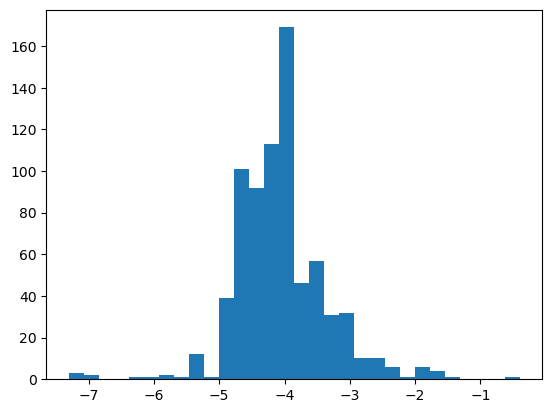

In [108]:
dataset_siz = X.shape[0]
y = np.array(y, dtype='f')
print(y)
log_y = -np.log10(y)
print(log_y)
plt.hist(log_y, bins=30)
plt.show()
y = log_y

Czy liczba zapalonych bitów fingerprintu koreluje z docking score? Chyba tak

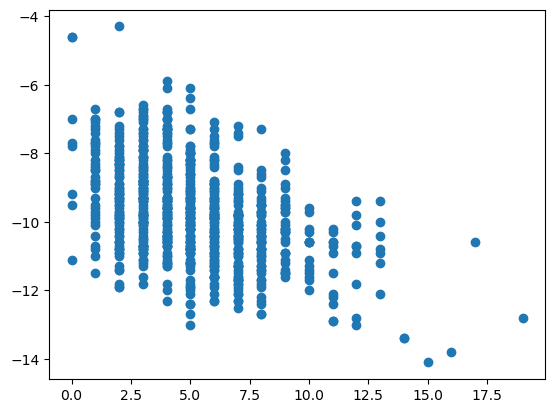

In [111]:
good_indices = np.argwhere(X[:, 0] < 0)
A = np.sum(X[:, 1:], axis=1)
plt.scatter(A[good_indices], X[good_indices, 0])
plt.show()

In [18]:
print(np.sum(X[:, 1:], axis=1))

[ 8.  7.  7.  6.  2.  3. 13.  9.  4.  7.  6.  3.  2.  2.  4.  6.  8.  3.
  5.  5.  5.  6.  7.  9.  2.  5.  3.  8.  4.  3.  4.  4.  4.  5.  7.  5.
  1.  4.  6.  7.  5.  3.  5.  6.  7.  4.  1.  2.  4.  7.  4. 10.  4.  7.
  3.  2.  5.  8.  4.  5.  4.  7.  6.  9.  2.  2.  8.  8.  6.  8.  7.  9.
  9.  7.  3.  8.  6.  7.  5.  5. 11.  5.  5.  1.  3.  9.  6.  2.  8.  5.
  5.  3. 11.  2.  5.  2. 11.  5.  4.  7.  4. 11.  1.  3.  9.  6.  2.  6.
  2.  8.  4.  8.  3. 12.  5.  7.  8.  2.  6.  6.  6.  5.  5.  4.  2.  8.
  5.  5.  4.  3.  5.  9.  8.  2.  3.  5.  7.  3.  3.  7.  9.  2.  6.  4.
  4.  7.  4.  3.  6.  1.  3.  5. 21.  5.  3.  3.  8.  5.  5.  4.  3.  9.
  4.  3.  3.  5.  5.  2.  9.  8.  3.  8.  6.  2.  2.  4.  4.  6.  7.  6.
  8. 11.  7.  5.  1.  9.  3.  3.  1.  6.  3.  2.  4.  5.  4.  3.  2.  2.
  8.  9.  9.  5.  3.  3.  8.  4.  1.  7.  5.  3.  2.  3.  2. 12.  6.  4.
  3.  3.  8.  2.  3.  7.  7.  2.  8.  5.  5.  4.  4.  5.  6.  5.  6.  2.
  7.  9.  3.  2.  5.  7.  6.  5.  1.  3.  3.  2.  3

## One can try to make the vector shorter

In [61]:
CUTOFF_THRESHOLD = 5

sums = np.sum(X, axis=0)
good_idces = np.argwhere(sums > CUTOFF_THRESHOLD).flatten()
print(good_idces)
# X = X[:, good_idces]
print(f'now every input vector has {X.shape[1]} bits and on average {np.sum(X[:, 1:]) / dataset_siz} of them is a 1')
print(f'example numbers of 1-bits: {np.sum(X, axis=1)[:20]}')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [110]:
rmse = Evaluator(name = 'RMSE')
mae = Evaluator(name = 'MAE')
r_squared = Evaluator(name = 'R2')

In [13]:
def test_model(model):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model.fit(x_train, y_train)

    fig, ax = plt.subplots()
    ax.axline((0, 0), slope=1)
    
    predictions = model.predict(x_train)  
    rmse_score = rmse(y_train, predictions)
    mae_score = mae(y_train, predictions)
    r2_score = r_squared(y_train, predictions)
    print(f'on train set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_train, predictions)

    predictions = model.predict(x_test) 
    rmse_score = rmse(y_test, predictions)
    mae_score = mae(y_test, predictions)
    r2_score = r_squared(y_test, predictions)
    print(f'on test set: RMSE, MAE, R2 = {rmse_score}, {mae_score}, {r2_score}')
    plt.scatter(y_test, predictions)
    plt.show()

on train set: RMSE, MAE, R2 = 0.2861298907536889, 0.20332075925470403, 0.8469766976149944
on test set: RMSE, MAE, R2 = 0.6831396897989486, 0.49894854836815955, -0.138315124915928


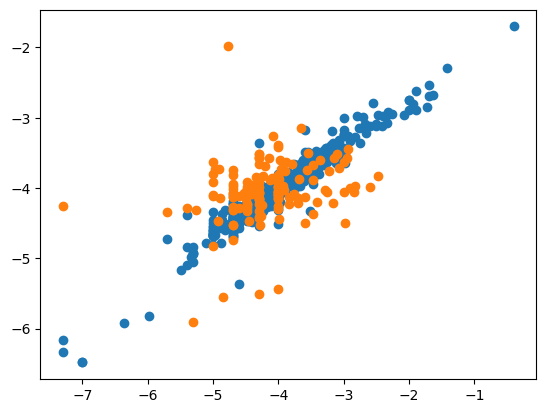

In [15]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# model = RandomForestRegressor(n_estimators=300, min_samples_leaf=2, verbose=1)
model = RandomForestRegressor()
test_model(model)

on train set: RMSE, MAE, R2 = 0.3834777959308947, 0.28026928422930936, 0.7251399904502918
on test set: RMSE, MAE, R2 = 0.9306852586051904, 0.6152536723071746, -1.1127550095682563


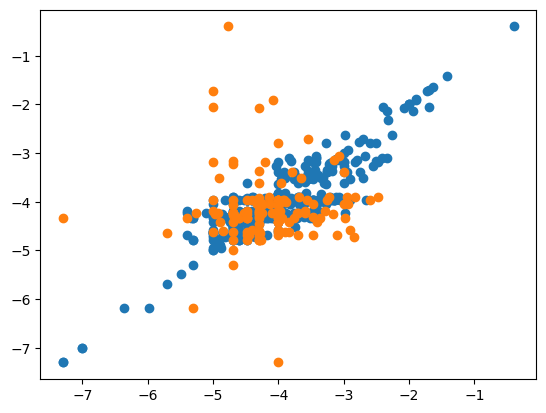

[Text(0.8337604334455997, 0.9821428571428571, 'x[0] <= -5.25\nsquared_error = 0.535\nsamples = 593\nvalue = -4.059'),
 Text(0.7050080538878313, 0.9464285714285714, 'x[0] <= -10.15\nsquared_error = 0.508\nsamples = 590\nvalue = -4.048'),
 Text(0.5037340752672427, 0.9107142857142857, 'x[73] <= 0.5\nsquared_error = 0.473\nsamples = 251\nvalue = -3.896'),
 Text(0.4849904817689266, 0.875, 'x[10] <= 0.5\nsquared_error = 0.426\nsamples = 250\nvalue = -3.91'),
 Text(0.3889295650900571, 0.8392857142857143, 'x[2] <= 0.5\nsquared_error = 0.369\nsamples = 210\nvalue = -3.962'),
 Text(0.3514423780934251, 0.8035714285714286, 'x[11] <= 0.5\nsquared_error = 0.361\nsamples = 195\nvalue = -3.991'),
 Text(0.3326987845951091, 0.7678571428571429, 'x[84] <= 0.5\nsquared_error = 0.356\nsamples = 193\nvalue = -3.982'),
 Text(0.2952115975984771, 0.7321428571428571, 'x[6] <= 0.5\nsquared_error = 0.371\nsamples = 165\nvalue = -3.943'),
 Text(0.2764680041001611, 0.6964285714285714, 'x[99] <= 0.5\nsquared_error = 

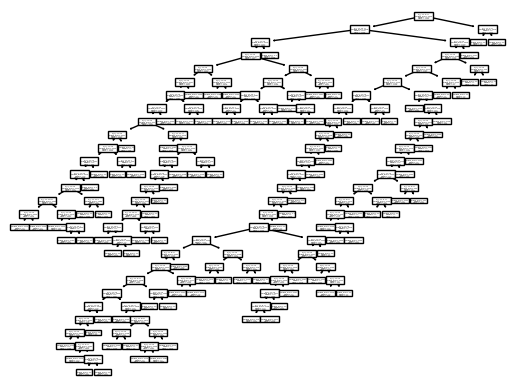

In [16]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tr = DecisionTreeRegressor(ccp_alpha=0.002)
test_model(tr)
plot_tree(tr)

on train set: RMSE, MAE, R2 = 0.0007948726885313988, 4.9456916309729796e-05, 0.9969431442096505
on test set: RMSE, MAE, R2 = 0.0138309571752813, 0.010221273396245067, 0.022206076450664525


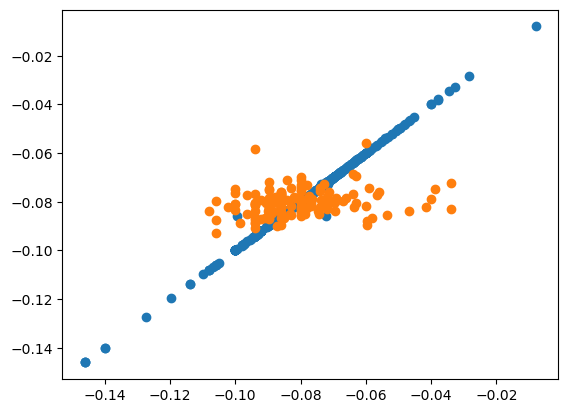

on train set: RMSE, MAE, R2 = 0.0019817148331574474, 0.00011508767359574368, 0.9968285947588673
on test set: RMSE, MAE, R2 = 0.038798059774687636, 0.02857510951400516, -0.05380147605594132


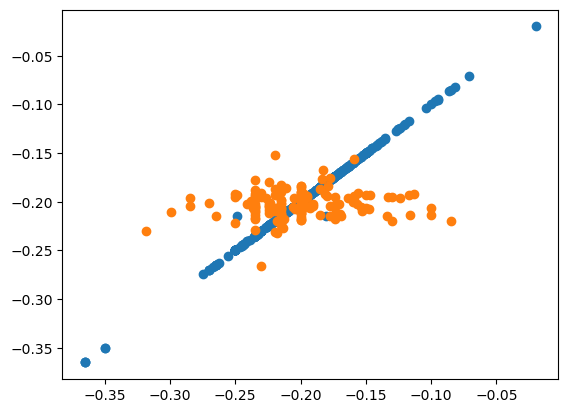

on train set: RMSE, MAE, R2 = 0.0052618230871629874, 0.00043116788840012445, 0.994559442149449
on test set: RMSE, MAE, R2 = 0.07160295309001723, 0.052418204077001436, 0.00031685223353550285


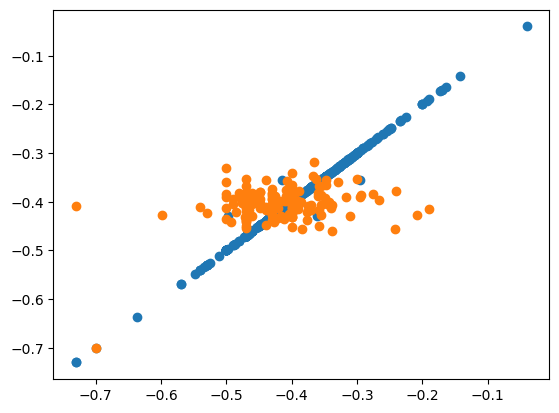

on train set: RMSE, MAE, R2 = 0.026309113562931342, 0.00215583929123002, 0.9948363361805271
on test set: RMSE, MAE, R2 = 0.3243073134688985, 0.24821005527657744, -0.02603568264557854


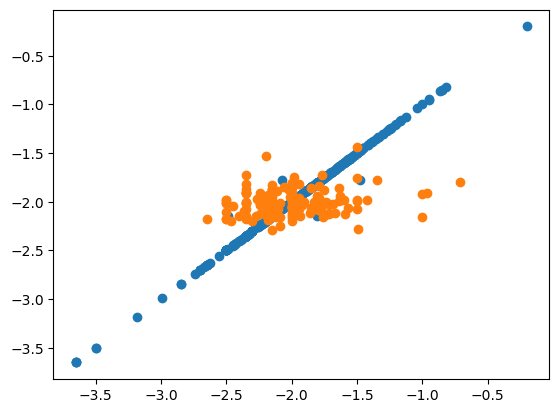

on train set: RMSE, MAE, R2 = 0.06921851279178877, 0.0040198506231452725, 0.9977937496770649
on test set: RMSE, MAE, R2 = 1.249417674056929, 0.9239798840418147, -0.01783224843696707


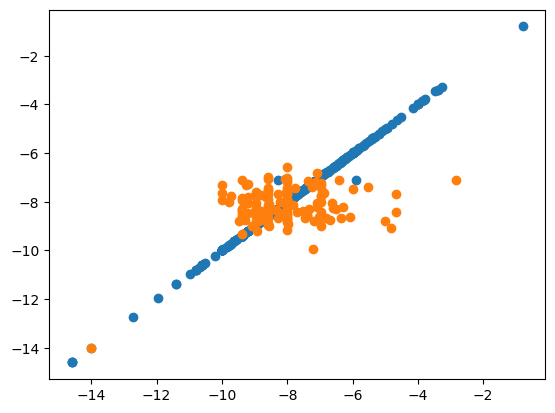

on train set: RMSE, MAE, R2 = 0.26350319126486604, 0.022413853650149366, 0.9947663725319349
on test set: RMSE, MAE, R2 = 3.294446510861969, 2.5136389268113533, -0.011762609565781457


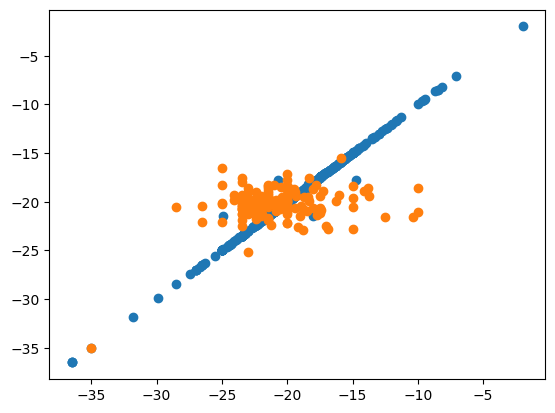

on train set: RMSE, MAE, R2 = 0.39743640139223424, 0.024728456596902006, 0.9969174691245243
on test set: RMSE, MAE, R2 = 7.2621217910452085, 5.320190343883205, -0.04222502401323269


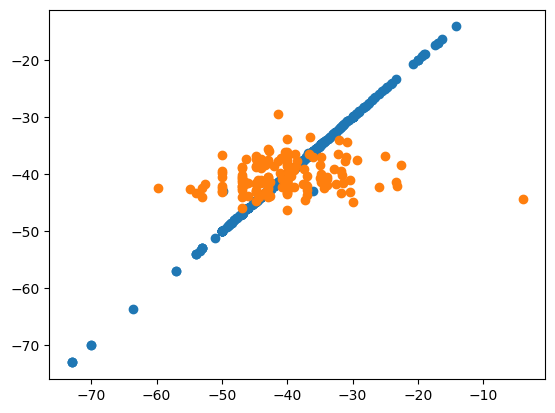

on train set: RMSE, MAE, R2 = 1.0523645713100367, 0.08623357325742055, 0.9947001586245218
on test set: RMSE, MAE, R2 = 14.356331534723573, 10.682343310066297, -0.10857633637726471


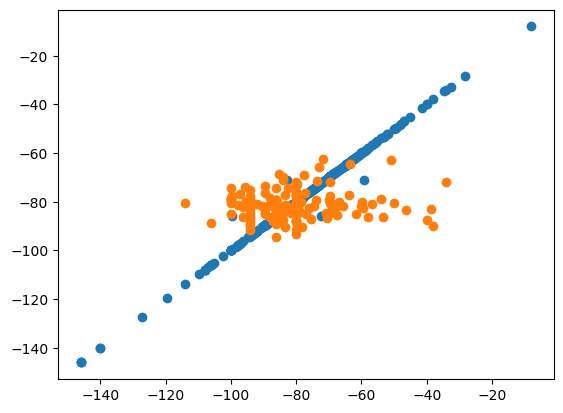

In [19]:
from sklearn.neighbors import KNeighborsRegressor

for alpha in [0.02, 0.05, 0.1, 0.5, 2.0, 5.0, 10.0, 20.0]:
    y_alpha = alpha * y
    x_train, x_test, y_train, y_test = train_test_split(X, y_alpha, test_size=0.2)
    model = KNeighborsRegressor(n_neighbors=10, weights='distance', metric='l1')
    test_model(model)

In [ ]:
docking_score_featurizer.featurize(protein_pdb_file, docked_ligands_target_directory)

In [ ]:
regr = DecisionTreeRegressor(random_state=1).fit(X_train, y_train.astype('float'))
regr.score(X_test, y_test.astype('float'))

## Binary classification for a change

In [104]:
high_pic50 = np.argwhere(y > -4).flatten()
yb = np.zeros(y.shape)
yb[high_pic50] = 1.0
yb = np.array(yb, dtype='i')
print(yb)
print(f'fraction of 1\'s: {sum(yb) / len(yb)})

[1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0
 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0
 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0
 1 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1
 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0
 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0
 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 1 1 0 0 0 

In [51]:
# Yeah, I'm super lazy, I didn't change variable names

rmse = Evaluator(name = 'Accuracy')
mae = Evaluator(name = 'Precision')
r_squared = Evaluator(name = 'Recall')

def test_classification_model(model):
    xb_train, xb_test, yb_train, yb_test = train_test_split(X, yb, test_size=0.2)
    model.fit(xb_train, yb_train)

    predictions = model.predict(xb_train)  
    print(predictions[:40])
    print(yb_train[:40])
    rmse_score = rmse(yb_train, predictions)
    mae_score = mae(yb_train, predictions)
    r2_score = r_squared(yb_train, predictions)
    print(f'on train set: Accuracy, Precision, Recall = {rmse_score}, {mae_score}, {r2_score}')

    predictions = model.predict(xb_test) 
    print(predictions[:36])
    print(yb_test[:36])
    rmse_score = rmse(yb_test, predictions)
    mae_score = mae(yb_test, predictions)
    r2_score = r_squared(yb_test, predictions)
    print(f'on test set: Accuracy, Precision, Recall = {rmse_score}, {mae_score}, {r2_score}')

In [52]:
from sklearn.svm import SVC

model = SVC()
test_classification_model(model)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0]
on train set: Accuracy, Precision, Recall = 0.6593591905564924, 0.0, 0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1
 0 1 0]
on test set: Accuracy, Precision, Recall = 0.7181208053691275, 0.0, 0.0


In [76]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(80, 50, 30, 10), alpha=1.5)
test_classification_model(model)

[1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0]
[1 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0
 0 0 1]
on train set: Accuracy, Precision, Recall = 0.9072512647554806, 0.9559748427672956, 0.76
[0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0]
[0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 1 0
 0 0 0]
on test set: Accuracy, Precision, Recall = 0.6711409395973155, 0.44680851063829785, 0.4772727272727273


In [92]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(min_samples_leaf=9)
test_classification_model(model)

[0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 1
 0 0 0]
on train set: Accuracy, Precision, Recall = 0.7521079258010118, 0.7175572519083969, 0.46078431372549017
[0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 0 1 0]
[1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1]
on test set: Accuracy, Precision, Recall = 0.6577181208053692, 0.36585365853658536, 0.375
